In [1]:
%run synthetic_data_generation.ipynb


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


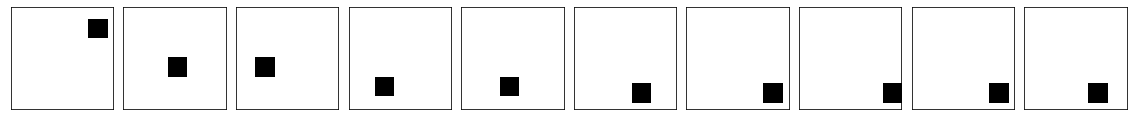

In [2]:
# Generate the sequence with the specified parameters
sequence = generate_random_sequence(
    sequence_length = 10,
    frame_rate = 60,
    speed_mean = 10,
    speed_sd = 5,
    direction_min = 0,
    direction_max = 2 * math.pi,
    position_x_mean = 8,
    position_x_sd= 2,
    position_y_mean = 8,
    position_y_sd = 2,
    gravity_mean = 9.81,
    gravity_sd = 2,
    restitution_min = 0.2,
    restitution_max = 0.8
)

#sequence.append(create_question_mark_image(IMAGE_WIDTH, IMAGE_HEIGHT, 40))

# Display the sequence
display_sequence(sequence)

In [3]:
import numpy as np

In [4]:
def create_n_sequences(n):
	sequences = []
	for _ in range(n):
		sequence = generate_random_sequence(
		sequence_length = 10,
		frame_rate = 60,
		speed_mean = 10,
		speed_sd = 5,
		direction_min = 0,
		direction_max = 2 * math.pi,
		position_x_mean = 8,
		position_x_sd= 2,
		position_y_mean = 8,
		position_y_sd = 2,
		gravity_mean = 9.81,
		gravity_sd = 2,
		restitution_min = 0.2,
		restitution_max = 0.8
		)
		sequences.append(sequence)
	return sequences
images_sequences = create_n_sequences(32)

In [5]:
len(images_sequences)

32

In [6]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Assuming you have a list of B sequences, each containing images of length L
# For example, images_sequences = [sequence1, sequence2, ..., sequenceB]
# Each sequence is a list of PIL images

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, sequences, transform=None):
        self.sequences = sequences
        self.transform = transform

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        if self.transform:
            sequence = [self.transform(img) for img in sequence]
        return torch.stack(sequence, dim=0)  # Stack images along the new dimension (sequence length)

# Define the transformations
transform = transforms.Compose([
    transforms.Grayscale(),  # Assuming your images are grayscale
    transforms.ToTensor()
])

# Create a custom dataset
# For example, images_sequences = [sequence1, sequence2, ..., sequenceB]
dataset = CustomDataset(images_sequences, transform=transform)

# Check if the dataset has a positive length
if len(dataset) == 0:
    raise ValueError("Dataset length is 0. Please check your data.")

# Create a data loader
batch_size = 32  # Set your desired batch size
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Iterate over the data loader
for batch in data_loader:
    # Your training/validation loop goes here
    batch = batch.permute(0, 1, 3, 4, 2)
    print(batch.shape)  # This will print the shape of each batch of tensors


torch.Size([32, 10, 16, 16, 1])


In [7]:
from video_prediction import VideoPrediction


VP = VideoPrediction(
    num_layers=5, 
    d_model=128, 
    num_heads=16, 
    dff=128, 
    filter_size=3,
    image_shape=(16,16), 
    pe_input=10, 
    pe_target=10, 
    out_channel=1,
    loss_function='mse', 
    optimizer='rmsprop'
)

VP.predict(data_loader.dataset[0], 1)

NotImplementedError: Module [Encoder] is missing the required "forward" function